In [1]:
## Import Libraries and The Data 
import h5py    
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline


f = h5py.File("data1.h5", "r")
f_name = list(f.keys())
data = f[f_name[0]][()]
invXForm = f[f_name[1]][()]
xForm = f[f_name[2]][()]

### Convert Data to Gray Scale and Plot
# converting the images to graysale using a luminosity model
gray_data = 0.2126 * data[:,0,:,:] + 0.7152 * data[:,1,:,:] + 0.0722 * data[:,2,:,:]
mean_data = (np.mean(gray_data, axis = (1,2))*np.ones(gray_data.shape).transpose()).transpose()
norm_data = gray_data - mean_data

#Clip the data
std = np.std(norm_data)
norm_data = np.minimum(norm_data, 3 * std)
norm_data = np.maximum(norm_data, -3 * std)

#Normalization the gray data between 0.1-0.9
minD, maxD = [0.1,0.9]
norm_data = minD + ((norm_data - norm_data.min())*(maxD - minD)/(norm_data.max() - norm_data.min()))

#Random number generation
rand = np.random.permutation(data.shape[0])

#Plot the RGB scale images
col = 8
row = 25
plt.figure(figsize = (10,40))
for i in range(col*row):
    plt.subplot(row,col,i+1)
    plt.imshow((data[rand[i],:,:,:].T))
    #plt.title('RGB: ' + str(i+1))
    plt.tight_layout
    plt.axis('off')
plt.show()

#Plot the gray scale images
plt.figure(figsize = (10,40))
for i in range(col*row):
    plt.subplot(row,col,i+1)
    plt.imshow(norm_data[rand[i],:,:].T, cmap = 'gray')
    #plt.title('Gray: ' + str(i+1))
    plt.tight_layout
    plt.axis('off')
plt.show()

### Set the Parameters

#The images of 16x16 should transformed into flat data set
#From (10240, 16, 16) to (10240, 256)
flat_data = np.reshape(norm_data,(norm_data.shape[0], norm_data.shape[1] ** 2))

#Initialization of the weights and bias
def w(L_pre, L_post):
    return np.sqrt(6/(L_pre+L_post))

def initialize_weights(L_param):
    np.random.seed(1)
    weights = []
    
    #The weights
    num = w(L_param[0],L_param[1])
    W = np.random.uniform(-num,num,(L_param[0],L_param[1]))
    weights.append(W)
    weights.append(W.T)
    
    #The biases
    num = w(L_param[0],L_param[1])
    b = np.random.uniform(-num,num,(1,L_param[1]))
    weights.append(b)
    num = w(L_param[1],L_param[2])
    b = np.random.uniform(-num,num,(1,L_param[2]))
    weights.append(b)
    
    return weights

### Cost Function
#Cost function calculation
def aeCost(W_e, data, params):
    '''
    W_e = a vector containing the weights for the first and second layers followed
by the bias terms
    data = desired output with size of (L_in,N)
    params = params is a structure with the following fields Lin
(Lin), Lhid (Lhid), lambda (λ), beta (β), rho (ρ).
    '''
    N = data.shape[0]
    hidden, output = forward_propagation(W_e, data)
    hidden_mean = np.mean(hidden, axis=0)
    
    #Calculation of given cost function
    J_1 = (np.sum((data - output) ** 2))/(2 * N)
    J_2 = ((np.sum(W_e[0] ** 2)) + (np.sum(W_e[1] ** 2))) * (params[2] / 2)
    KL_1 = np.log(hidden_mean / params[4]) * params[4]
    KL_2 = np.log((1 - params[4]) / (1 - hidden_mean)) * (1 - params[4])
    J_3 = np.sum(KL_1 + KL_2) * params[3]      
    
    J = J_1 + J_2 + J_3
    
    dOut = (output - data)* sigmoidDerivative(output)
    dKL = np.tile(params[3]*(-(params[4]/hidden_mean.T)+((1-params[4])/(1-hidden_mean.T))), (10240,1)).T
    dHidden = (np.matmul(W_e[1],dOut.T)+ dKL) * sigmoidDerivative(hidden).T
    
    dW2 = (1/N)*(np.matmul(dOut.T,hidden).T + params[2] * W_e[1])
    db2 = np.mean(dOut, axis=0)

    dW1 = (1/N)*(np.matmul(data.T,dHidden.T) + params[2] * W_e[0])
    db1 = np.mean(dHidden, axis=1)
    #Calculation of gradients
    #J_grad = backward_propagation(W_e, output, data)

    return [J, [dW1, dW2, db1.T, db2.T]]
    
    
### Parameter Update
#Update the parameters
def update_param(W_e, data, params, learning_rate , J_grad):
    N = data.shape[0]
    
    weights = []
    
    W = W_e[0] - J_grad[0] * learning_rate
    weights.append(W)
    W = W_e[1] - J_grad[1] * learning_rate
    weights.append(W)
    
    b = W_e[2] - J_grad[2] * learning_rate
    weights.append(b)
    b = W_e[3] - J_grad[3] * learning_rate
    weights.append(b)
        
    return weights

def sigmoid(x):
    #Sigmoid Function

    return 1.0/ (1.0 + np.exp(-x))
    
def sigmoidDerivative(x):
    #Sigmoid Derivative
    s = 1/(1+np.exp(-x))
    return s * (1-s)

def relu(Z):

    return np.maximum(0,Z)

def relu_backward(A):
    dZ = np.array(A, copy=True) # just converting dz to a correct object.

    dZ[A <= 0] = 0
    
    return dZ

### Forward Propagation

def forward_propagation(W_e, data):
    
    hidden = sigmoid(np.dot(data, weights[0]) + weights[2])
    out = sigmoid(np.dot(hidden, weights[1]) + weights[3])
    
    return hidden, out

## Model

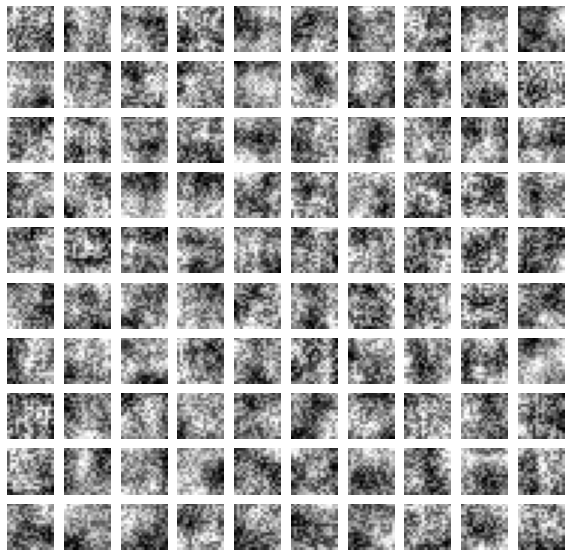

In [134]:
L_in = flat_data.shape[1]
L_out = flat_data.shape[1]
L_hidden = 100
lambd = (10 ** (-3))
beta = 0.01
rho = 0.5
L_param = [L_in,L_hidden,L_out]
params = [L_in, L_hidden, lambd, beta, rho]
learning_rate = 0.3
cost = []

weights = initialize_weights(L_param)
num_epochs = 1000
for i in range(num_epochs):
    J, J_grad = aeCost(weights, flat_data, params)
    weights = update_param(weights, data, params, learning_rate , J_grad)
hidden_data = np.reshape(weights[0],(int(weights[0].shape[0]**0.5 ),int(weights[0].shape[0]**0.5),weights[0].shape[1]))

#Demonstration of the hidden layer
col = 10
row = 10
plt.figure(figsize = (10,10))
for i in range(col*row):
    plt.subplot(row,col,i+1)
    plt.imshow(hidden_data[:,:,i],cmap = 'gray')
    plt.tight_layout
    plt.axis('off')
plt.show()